### Dataset and DataLoaders

In [7]:
import os, torch, json, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
torch.manual_seed(2024)

class CustomDataset(Dataset):
    
    def __init__(self, root, transformations=None, drop_class=None):
        
        self.transformations, self.root = transformations, root
        
        json_file = json.load(open(f"{root}/sky_classification_export.json"))
        
        self.im_paths, self.classes = [], []
        for idx, data in enumerate(json_file):
            if not "choice" in data: continue
            if drop_class is not None and data["choice"] == drop_class: continue
            else: 
                if data["choice"] == "roads":
                    self.classes.append("others")  # Map "roads" to "others"
                else:
                    self.classes.append(data["choice"])
                self.im_paths.append(data["image"])
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        
        for idx, cls_name in enumerate(self.classes):
            if cls_name not in self.cls_names: 
                self.cls_names[cls_name] = count
                self.cls_counts[cls_name] = 1
                count += 1
            else: 
                self.cls_counts[cls_name] += 1
            
    def get_im_gt(self, idx): return (Image.open(f"{self.root}/{self.im_paths[idx]}").convert("RGB"), self.cls_names[self.classes[idx]])
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt  = self.get_im_gt(idx)
        
        if self.transformations is not None: im = self.transformations(image=np.array(im))["image"]
        
        return im, gt
    
def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4, drop_class=None):
    
    ds = CustomDataset(root=root, transformations=transformations, drop_class=drop_class)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])
    
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/kaggle/input/aerial-drone-urban-classification/sky_classification_export"
im_size = 224

train_tfs = A.Compose([
    A.Resize(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_tfs = A.Compose([
    A.Resize(im_size, im_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=train_tfs, bs=32, drop_class="roads")

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
print(classes)

48
3
85
{'commercial': 0, 'residential': 1, 'other': 2, 'nature': 3}


### Data Visualization

/tmp/ipykernel_26/1806462382.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation=60, ha='right')


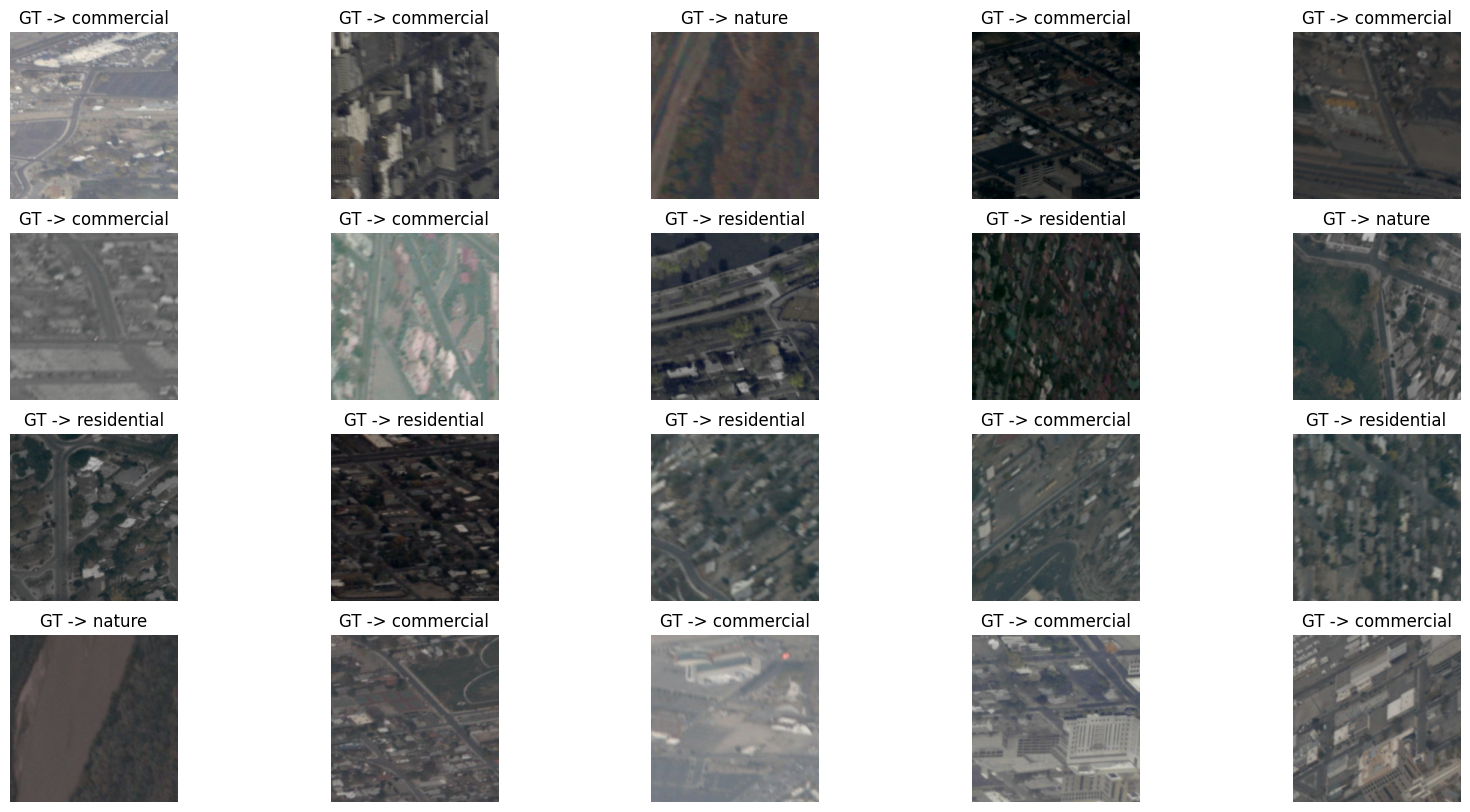

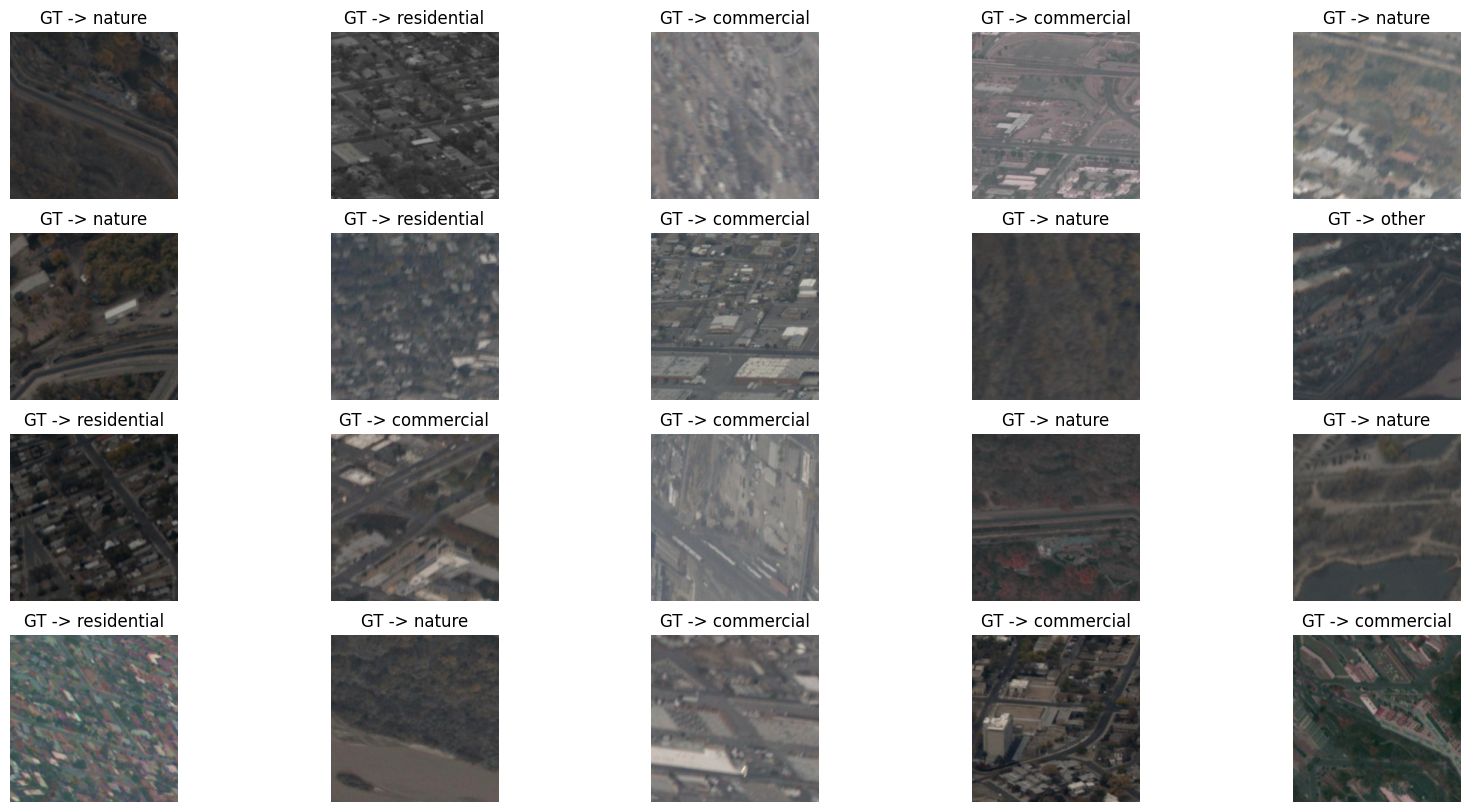

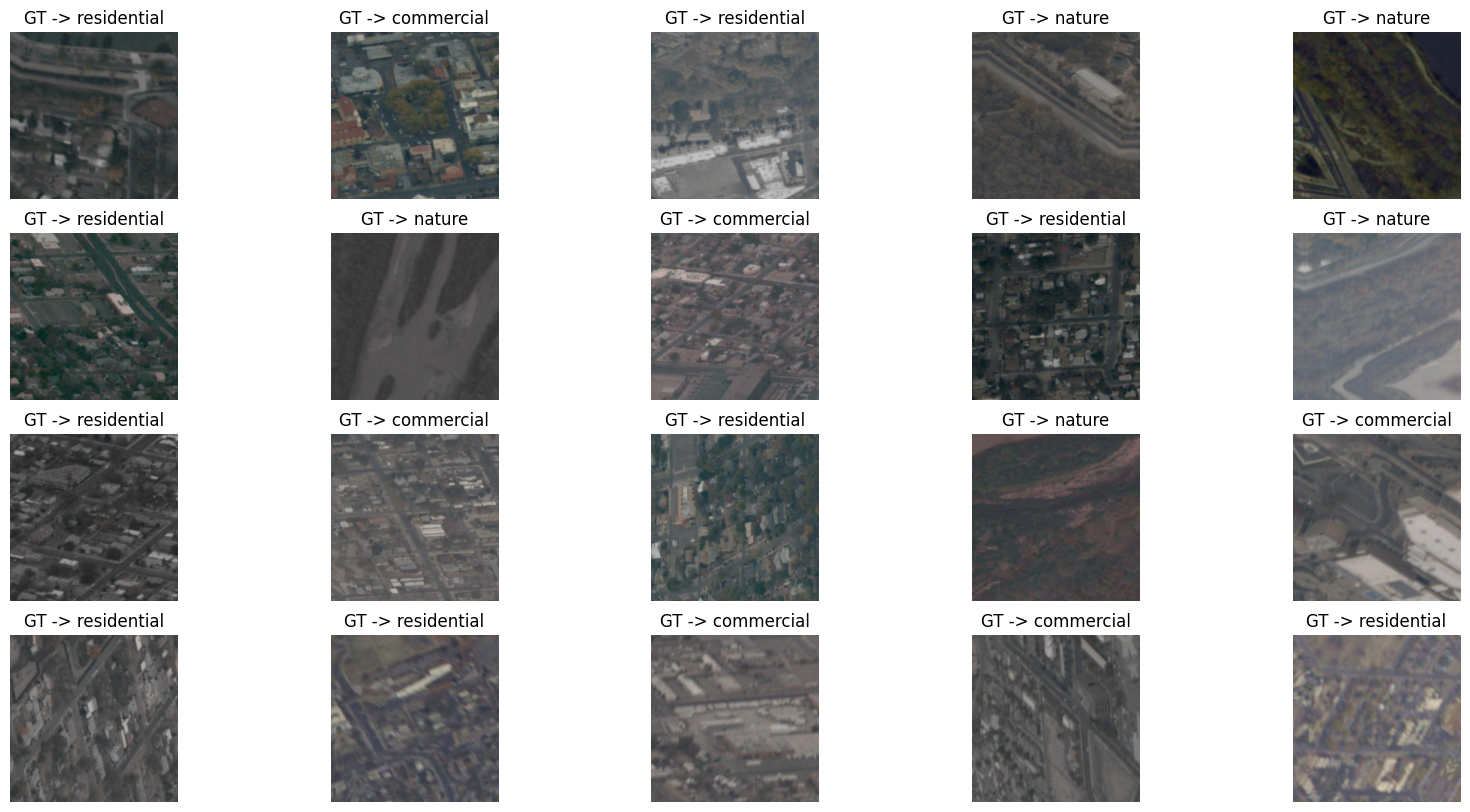

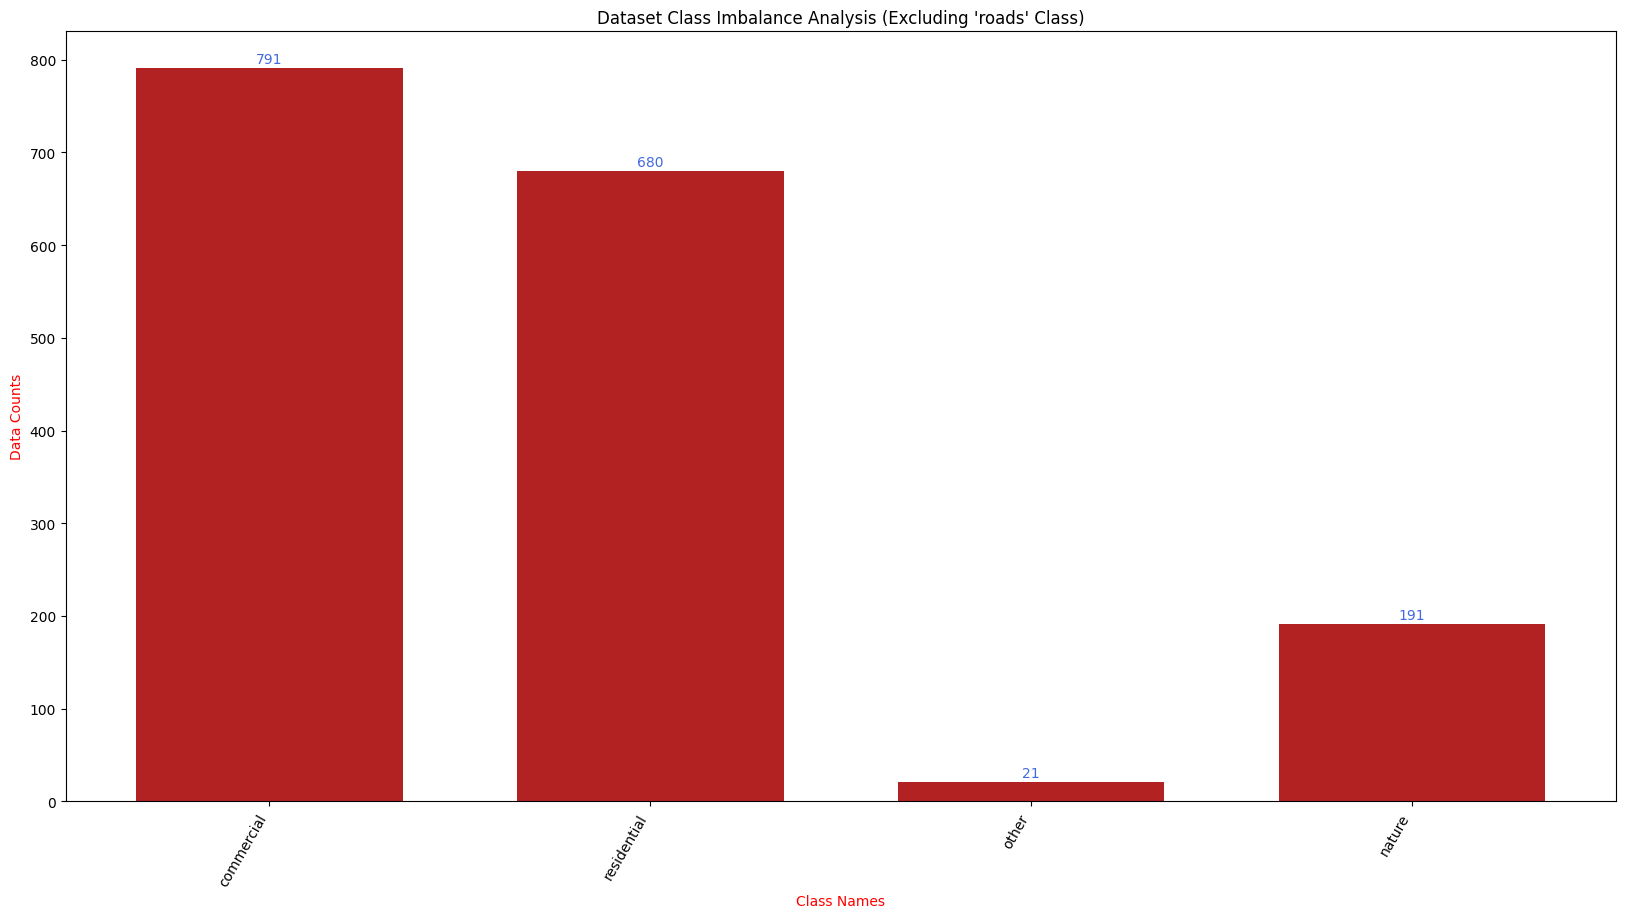

In [8]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type="rgb"):
    gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
    rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]), T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    assert cmap in ["rgb", "gray"], "Please specify if the image is grayscale or color!"
    if cmap == "gray":
        cmap = "gray"
    else:
        cmap = None
    
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(data)), n_ims)
    for idx, index in enumerate(indices):
        im, gt = data[index]
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None:
            if cls_names[int(gt)] == "roads":
                plt.title(f"GT -> others")
            else:
                plt.title(f"GT -> {cls_names[int(gt)]}")
        else:
            plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

def data_analysis(root, transformations, drop_class=None):
    
    ds = CustomDataset(root=root, transformations=transformations, drop_class=drop_class)
    cls_counts, width, text_width = ds.cls_counts, 0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize=(20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60, ha='right')
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis (Excluding '{drop_class}' Class)")

    for i, v in enumerate(counts):
        ax.text(i, v + text_height, str(v), color="royalblue", ha='center', va='bottom')
    
data_analysis(root=root, transformations=val_tfs, drop_class="roads")

### Data Analysis

### Train and Validation

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Start training...


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

1-epoch train process is completed!
1-epoch train loss          -> 1.308
1-epoch train accuracy      -> 0.623



100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


1-epoch validation process is completed!
1-epoch validation loss     -> 0.621
1-epoch validation accuracy -> 0.750


100%|██████████| 48/48 [00:19<00:00,  2.44it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.718
2-epoch train accuracy      -> 0.760



100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

2-epoch validation process is completed!
2-epoch validation loss     -> 0.725
2-epoch validation accuracy -> 0.762
Loss value did not decrease for 1 epochs



100%|██████████| 48/48 [00:19<00:00,  2.40it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.572
3-epoch train accuracy      -> 0.802



100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

3-epoch validation process is completed!
3-epoch validation loss     -> 0.685
3-epoch validation accuracy -> 0.786
Loss value did not decrease for 2 epochs



100%|██████████| 48/48 [00:20<00:00,  2.35it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.514
4-epoch train accuracy      -> 0.832



100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


4-epoch validation process is completed!
4-epoch validation loss     -> 0.481
4-epoch validation accuracy -> 0.798


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.491
5-epoch train accuracy      -> 0.820



100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

5-epoch validation process is completed!
5-epoch validation loss     -> 0.490
5-epoch validation accuracy -> 0.821
Loss value did not decrease for 1 epochs



100%|██████████| 48/48 [00:20<00:00,  2.29it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.438
6-epoch train accuracy      -> 0.844



100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


6-epoch validation process is completed!
6-epoch validation loss     -> 0.479
6-epoch validation accuracy -> 0.833


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.373
7-epoch train accuracy      -> 0.857



100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


7-epoch validation process is completed!
7-epoch validation loss     -> 0.474
7-epoch validation accuracy -> 0.833


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.387
8-epoch train accuracy      -> 0.861



100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

8-epoch validation process is completed!
8-epoch validation loss     -> 0.596
8-epoch validation accuracy -> 0.762
Loss value did not decrease for 1 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.368
9-epoch train accuracy      -> 0.866



100%|██████████| 3/3 [00:00<00:00,  5.80it/s]


9-epoch validation process is completed!
9-epoch validation loss     -> 0.473
9-epoch validation accuracy -> 0.857


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.357
10-epoch train accuracy      -> 0.875



100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

10-epoch validation process is completed!
10-epoch validation loss     -> 0.548
10-epoch validation accuracy -> 0.833
Loss value did not decrease for 1 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

11-epoch train process is completed!
11-epoch train loss          -> 0.333
11-epoch train accuracy      -> 0.875



100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

11-epoch validation process is completed!
11-epoch validation loss     -> 0.589
11-epoch validation accuracy -> 0.774
Loss value did not decrease for 2 epochs



100%|██████████| 48/48 [00:20<00:00,  2.32it/s]

12-epoch train process is completed!
12-epoch train loss          -> 0.293
12-epoch train accuracy      -> 0.886



100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

12-epoch validation process is completed!
12-epoch validation loss     -> 0.689
12-epoch validation accuracy -> 0.798
Loss value did not decrease for 3 epochs



100%|██████████| 48/48 [00:20<00:00,  2.32it/s]

13-epoch train process is completed!
13-epoch train loss          -> 0.305
13-epoch train accuracy      -> 0.885



100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

13-epoch validation process is completed!
13-epoch validation loss     -> 0.485
13-epoch validation accuracy -> 0.798
Loss value did not decrease for 4 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

14-epoch train process is completed!
14-epoch train loss          -> 0.312
14-epoch train accuracy      -> 0.880



100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

14-epoch validation process is completed!
14-epoch validation loss     -> 0.530
14-epoch validation accuracy -> 0.786
Loss value did not decrease for 5 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

15-epoch train process is completed!
15-epoch train loss          -> 0.260
15-epoch train accuracy      -> 0.901



100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


15-epoch validation process is completed!
15-epoch validation loss     -> 0.473
15-epoch validation accuracy -> 0.833


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

16-epoch train process is completed!
16-epoch train loss          -> 0.271
16-epoch train accuracy      -> 0.895



100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

16-epoch validation process is completed!
16-epoch validation loss     -> 0.580
16-epoch validation accuracy -> 0.798
Loss value did not decrease for 1 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

17-epoch train process is completed!
17-epoch train loss          -> 0.214
17-epoch train accuracy      -> 0.918



100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

17-epoch validation process is completed!
17-epoch validation loss     -> 0.558
17-epoch validation accuracy -> 0.833
Loss value did not decrease for 2 epochs



100%|██████████| 48/48 [00:20<00:00,  2.31it/s]

18-epoch train process is completed!
18-epoch train loss          -> 0.236
18-epoch train accuracy      -> 0.912



100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

18-epoch validation process is completed!
18-epoch validation loss     -> 0.634
18-epoch validation accuracy -> 0.845
Loss value did not decrease for 3 epochs



100%|██████████| 48/48 [00:20<00:00,  2.32it/s]

19-epoch train process is completed!
19-epoch train loss          -> 0.219
19-epoch train accuracy      -> 0.913



100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

19-epoch validation process is completed!
19-epoch validation loss     -> 0.524
19-epoch validation accuracy -> 0.833
Loss value did not decrease for 4 epochs



100%|██████████| 48/48 [00:20<00:00,  2.32it/s]

20-epoch train process is completed!
20-epoch train loss          -> 0.232
20-epoch train accuracy      -> 0.919



100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


20-epoch validation process is completed!
20-epoch validation loss     -> 0.587
20-epoch validation accuracy -> 0.821
Loss value did not decrease for 5 epochs


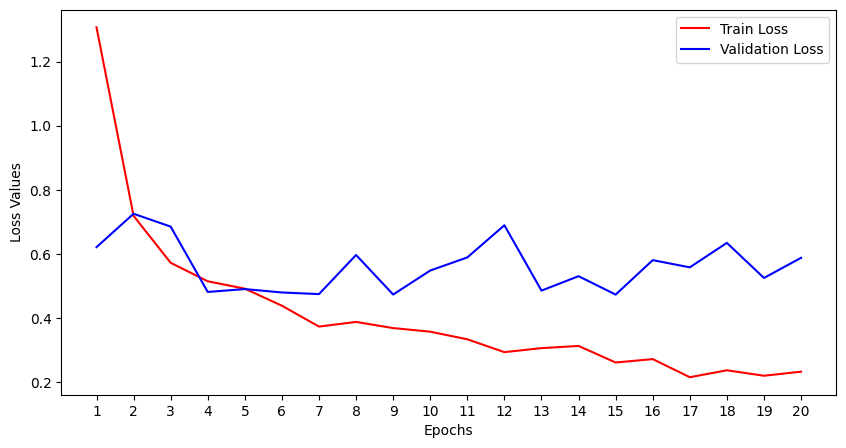

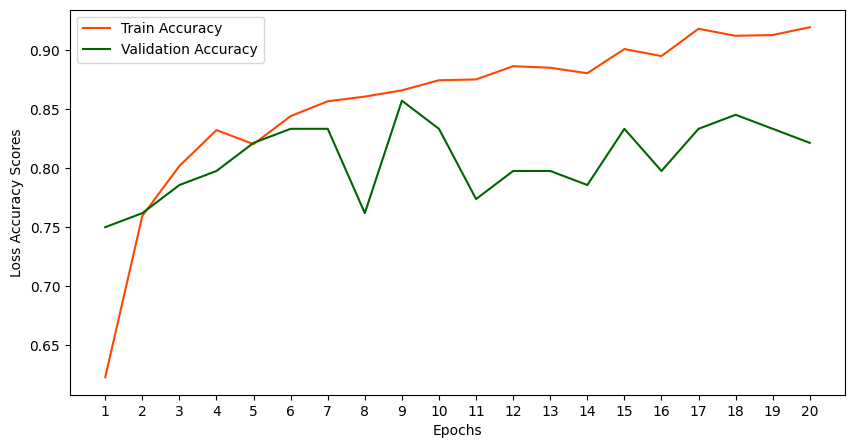

In [9]:
import timm
import torch
from tqdm import tqdm

try:
    m = timm.create_model("tf_efficientnet_b4", pretrained=True, num_classes=len(classes))  
except Exception as e:
    print(f"Failed to download pretrained weights. Using randomly initialized weights instead. Error: {str(e)}")
    m = timm.create_model("tf_efficientnet_b4", pretrained=False, num_classes=len(classes))

def train_setup(m):
    return m.to("cuda"), 20, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.AdamW(params=m.parameters(), lr=1e-4)

def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item()

m, epochs, device, loss_fn, optimizer = train_setup(m)

save_prefix, save_dir = "aerial", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 7
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    m.train()
    epoch_loss, epoch_acc = 0, 0
    for idx, batch in tqdm(enumerate(tr_dl), total=len(tr_dl)):
        ims, gts = to_device(batch, device)
        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in tqdm(enumerate(val_dl), total=len(val_dl)):
            ims, gts = to_device(batch, device)
            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim=1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < best_loss:
            os.makedirs(save_dir, exist_ok=True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            not_improved = 0
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

def learning_curves(tr_losses, val_losses, tr_accs, val_accs):
    
    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "orangered")
    plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()
    
learning_curves(tr_losses, val_losses, tr_accs, val_accs)

### Learning Curves

In [20]:
best_model_path = f"{save_dir}/{save_prefix}_best_model.pth"
m.load_state_dict(torch.load(best_model_path))
m.eval()

test_acc = 0
with torch.no_grad():
    for batch in tqdm(ts_dl, total=len(ts_dl)):
        ims, gts = to_device(batch, device)
        preds = m(ims)
        test_acc += (torch.argmax(preds, dim=1) == gts).sum().item()

test_acc /= len(ts_dl.dataset)
print(f"Test accuracy: {test_acc:.3f}")

final_conv = m.conv_head
fc_params = list(m.classifier.parameters())

num_ims = 10
row = 2
inference(m, device, ts_dl, num_ims, row, final_conv, fc_params, cls_names=list(classes.keys()))

100%|██████████| 85/85 [00:02<00:00, 38.05it/s]

Test accuracy: 0.835



85it [00:01, 43.13it/s]

Accuracy of the model on the test data -> 0.882
